In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [6]:
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [7]:
len(words)

32033

In [17]:
# build the vocabulary of characters and mapping to/from ints
chars = sorted(set(list(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = reversed(stoi)
itos = {i:s for s, i in stoi.items()}

In [239]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []

for w in words[:5]:
    print(w)
    expanded_word = '.'*block_size + w
    for i, (x, y) in enumerate(zip(expanded_word, w+'.')):
        X.append([stoi[expanded_word[k]] for k in range(i, i+block_size)])
        Y.append(stoi[y])
        print(f'{''.join([itos[j] for j in X[-1]])} -----> {y}')

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... -----> e
..e -----> m
.em -----> m
emm -----> a
mma -----> .
olivia
... -----> o
..o -----> l
.ol -----> i
oli -----> v
liv -----> i
ivi -----> a
via -----> .
ava
... -----> a
..a -----> v
.av -----> a
ava -----> .
isabella
... -----> i
..i -----> s
.is -----> a
isa -----> b
sab -----> e
abe -----> l
bel -----> l
ell -----> a
lla -----> .
sophia
... -----> s
..s -----> o
.so -----> p
sop -----> h
oph -----> i
phi -----> a
hia -----> .


In [42]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [45]:
C = torch.randn((27, 2))
C

tensor([[ 0.8870, -1.5686],
        [-0.4000,  0.4145],
        [-1.0300,  1.0387],
        [ 0.1065, -0.3781],
        [-1.4015,  0.2530],
        [ 0.8072, -0.5592],
        [-0.6381, -1.5295],
        [ 1.6929,  0.3401],
        [ 1.0718, -0.9760],
        [-1.0135, -0.2716],
        [-1.1270,  0.6658],
        [-0.3562,  0.4413],
        [ 0.0426,  0.7348],
        [ 1.1643,  1.8471],
        [-1.2873,  2.4423],
        [ 0.2946,  0.2865],
        [-0.2674,  0.9597],
        [ 0.3423, -0.0964],
        [ 0.7108,  0.7307],
        [-1.0887,  0.5018],
        [ 1.5496, -0.7767],
        [ 1.7174,  0.1985],
        [-0.3710,  1.2326],
        [ 0.2781, -0.1558],
        [ 0.2753,  0.2755],
        [ 0.4004,  1.2411],
        [-0.0324,  0.8313]])

In [57]:
C[5]
# alternative way (but slower): F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([ 0.8072, -0.5592])

In [66]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [97]:
W1 = torch.randn((3*2, 100))
b1 = torch.randn(100)
W1.shape, b1.shape

(torch.Size([6, 100]), torch.Size([100]))

In [72]:
emb @ W1 + b1

RuntimeError: mat1 and mat2 shapes cannot be multiplied (96x2 and 6x100)

In [78]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

torch.Size([32, 6])

In [86]:
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([32, 6])

In [103]:
h = torch.tanh(emb.view(32, 6) @ W1 + b1)
h.shape

torch.Size([32, 100])

In [104]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [105]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [107]:
counts = logits.exp()

prob = counts / counts.sum(1, keepdim=True)

In [139]:
prob.shape

torch.Size([32, 27])

In [119]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.6115)

In [527]:
context_len = 5 # context length: how many characters do we take to predict the next one?
embedding_size = 30
hidden_size = 500

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, embedding_size), requires_grad=True, generator=g)
W1 = torch.randn((context_len * embedding_size, hidden_size), requires_grad=True, generator=g)
b1 = torch.randn(hidden_size, requires_grad=True, generator=g)
W2 = torch.randn((hidden_size, 27), requires_grad=True, generator=g)
b2 = torch.randn(27, requires_grad=True, generator=g)

parameters = [C, W1, b1, W2, b2]

In [502]:
num_parameters = sum(map(torch.numel, parameters))
(sum([(p.view(-1)**2).sum() for p in parameters]) / num_parameters).item()

1.0027492046356201

In [503]:
sum(map(torch.numel, parameters))

36437

In [528]:

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        expanded_word = '.'*context_len + w
        for i, (x, y) in enumerate(zip(expanded_word, w+'.')):
            X.append([stoi[expanded_word[k]] for k in range(i, i+context_len)])
            Y.append(stoi[y])
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

X, Y = build_dataset(words)

In [529]:
import random

random.seed(42)

random.shuffle(words)
training_split = int(0.8*len(words))
dev_split = int(0.9*len(words))

X_train, Y_train = build_dataset(words[:training_split])
X_dev, Y_dev = build_dataset(words[training_split:dev_split])
X_test, Y_test = build_dataset(words[dev_split:])

In [530]:
training_split, dev_split

(25626, 28829)

In [531]:
X.shape, Y.shape

(torch.Size([228146, 5]), torch.Size([228146]))

In [532]:
def softmax(inputs):
    counts = inputs.exp()
    probs = counts / counts.sum(1, keepdim=True)
    return probs

In [533]:
def forward(inputs):
    # inputs: N x context_length
    # C: 27 x 2
    # C[xs] N x context_length x 2
    num_examples = inputs.shape[0]
    first_layer = C[inputs].view(num_examples, context_len*embedding_size) @ W1 + b1 # N x 100
    second_layer = torch.tanh(first_layer) @ W2 + b2 # N x 27
    return second_layer # N x 27

In [534]:
num_examples = torch.arange(X.shape[0])
logits = forward(X) # N x 27
F.cross_entropy(logits, Y)

tensor(40.5639, grad_fn=<NllLossBackward0>)

In [512]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [555]:
num_examples = torch.arange(X.shape[0])
learning_rate = 0.01
num_parameters = sum(map(torch.numel, parameters))
iteration = 50000
batch_size = 128

lri = []
lossi = []
stepi = []

In [556]:
for i in range(iteration):
    stepi.append(i)
    
    batch_index = torch.randint(0, X_train.shape[0], (batch_size, ))
    
    logits = forward(X_train[batch_index]) # N x 27
    # mse = (sum([(p.view(-1)**2).sum() for p in parameters]) / num_parameters).item()

    loss = F.cross_entropy(logits, Y_train[batch_index]) # + mse # N x 1

    #print(f'loss = {loss}')

    for p in parameters:
        p.grad = None

    loss.backward()
    
    #learning_rate = lrs[i]

    #lri.append(lre[i])
    lossi.append(loss.log10().item())

    for p in parameters:
        #decay = max(0.2, (iteration - i + 1) / iteration)
        p.data += -learning_rate * p.grad # * decay

logits = forward(X_train)
loss = F.cross_entropy(logits, Y_train)

print(f'loss = {loss}')

loss = 1.8573143482208252


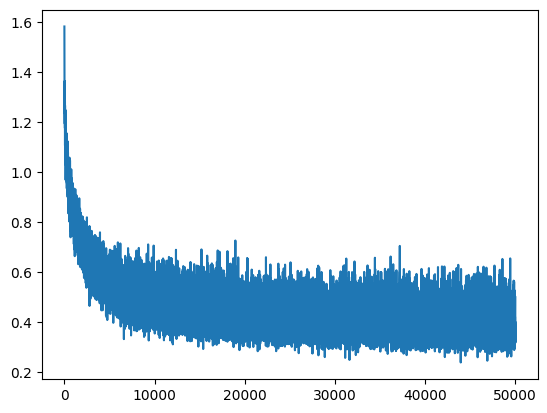

In [537]:
plt.plot(stepi, lossi)

In [557]:
logits = forward(X_dev) # N x 27
loss = F.cross_entropy(logits, Y_dev) # + mse # N x 1
print(f'dev loss = {loss}')

dev loss = 2.2360570430755615


In [470]:
C.shape

torch.Size([27, 2])

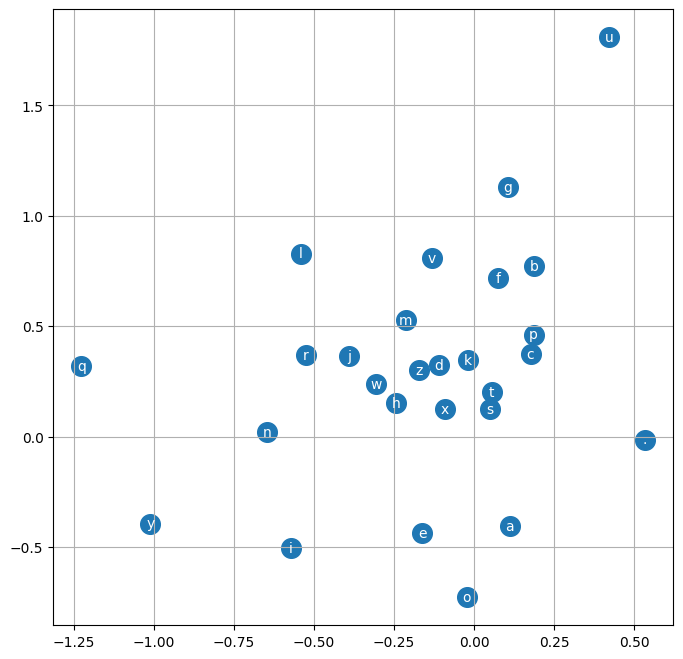

In [471]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)

for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i, 1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

In [558]:
def predict(n):
    g = torch.Generator().manual_seed(2147483647)

    for i in range(n):
        out = []
        context = [0] * context_len

        while True:
            logits = forward(torch.tensor([context]))
            probs = F.softmax(logits, dim=1)
            pred_y = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()

            out.append(itos[pred_y])
            
            if pred_y == 0:
                break

            context = context[1:] + [pred_y]
        print(''.join(out))

predict(10)

celie.
mouli.
raileighanner.
jimitham.
rakayn.
katar.
samiyah.
jaleigh.
tai.
molie.


In [315]:
torch.randint(0, 5, (32,))

tensor([1, 3, 3, 1, 3, 3, 3, 1, 3, 1, 3, 2, 0, 0, 2, 2, 2, 1, 4, 1, 0, 3, 3, 4,
        4, 4, 3, 3, 4, 2, 2, 4])

In [ ]:
# training split, dev/validation split, test split
# 80%, 10%, 10%
# train parameters, train hyper-parameters, test

